<a href="https://colab.research.google.com/github/vzaisun/Emotion-recognition-using-explainable-AI/blob/main/Emotion_recognition_using_gradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import os

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import auc,roc_curve,roc_auc_score
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
print("Tensorflow version:", tf.__version__)

import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

!git clone https://github.com/samson6460/tf_keras_gradcamplusplus.git
from tf_keras_gradcamplusplus.utils import vgg16_mura_model, preprocess_image, show_imgwithheat
from tf_keras_gradcamplusplus.gradcam import grad_cam, grad_cam_plus


from IPython.display import SVG, Image

!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

!pip install -q git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs

!pip install opencv-python

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)


Tensorflow version: 2.15.0
Cloning into 'tf_keras_gradcamplusplus'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 105 (delta 39), reused 82 (delta 22), pack-reused 0
Receiving objects: 100% (105/105), 13.66 MiB | 24.46 MiB/s, done.
Resolving deltas: 100% (39/39), done.
  Preparing metadata (setup.py) ... done


sklearn.metrics.ConfusionMatrixDisplay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename));


base_dir = '/content/drive/MyDrive/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge'


os.listdir(base_dir)

['icml_face_data.csv']

In [4]:
df = pd.read_csv(base_dir+'/icml_face_data.csv')
df.columns = ['emotion', 'Usage', 'pixels']
df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [5]:
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [6]:
df['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

Training for training
rest for testing


In [7]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}


Our dataset is imbalanced with Disgust being the smallest minority class.However, instead of correcting this imbalance, we will use a stratified sampling strategy where we make a simplifying assumption that this imbalance between the label distribution is reflected in the real world.

<ipython-input-8-e5463f644860>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(emotions.values())
<ipython-input-8-e5463f644860>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(emotions.values())
<ipython-input-8-e5463f644860>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(emotions.values())


[Text(0, 0, 'Angry'),
 Text(1, 0, 'Disgust'),
 Text(2, 0, 'Fear'),
 Text(3, 0, 'Happy'),
 Text(4, 0, 'Sad'),
 Text(5, 0, 'Surprise'),
 Text(6, 0, 'Neutral')]

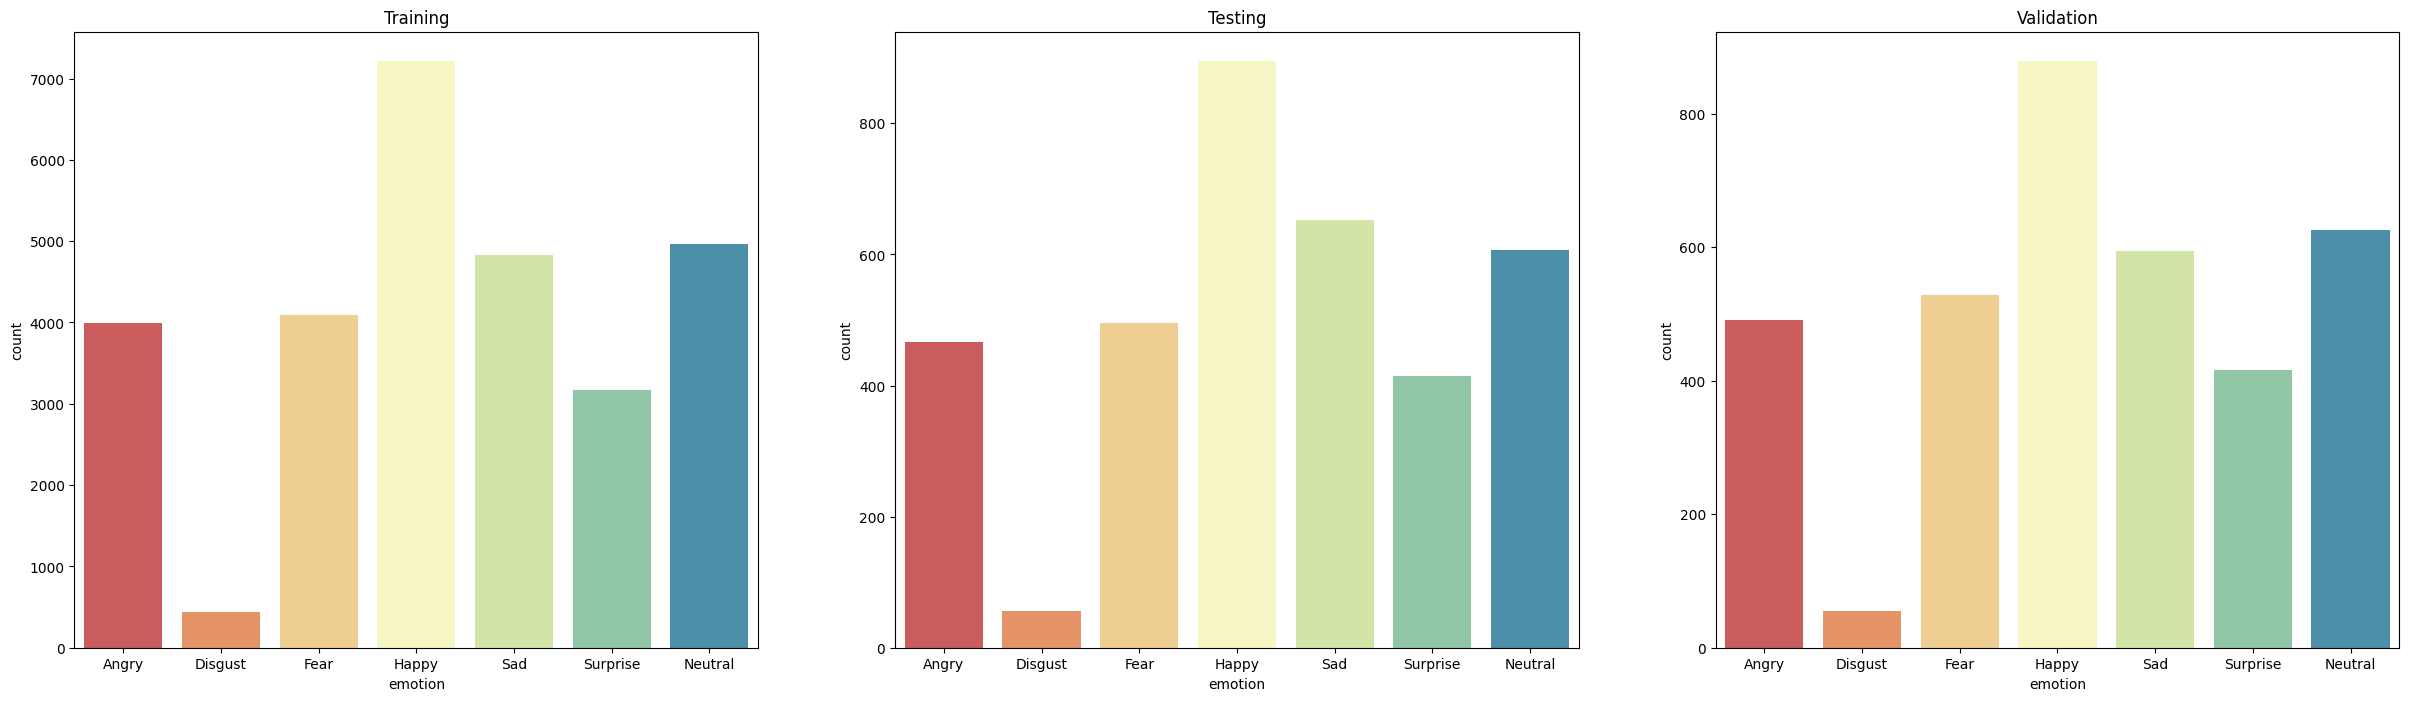

In [8]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(30,8))

sns.countplot(data = df[df['Usage']=='Training'], x='emotion', ax=ax1, palette='Spectral').set_title('Training')
ax1.set_xticklabels(emotions.values())

sns.countplot(data = df[df['Usage']=='PublicTest'], x='emotion', ax=ax2, palette='Spectral').set_title('Testing')
ax2.set_xticklabels(emotions.values())

sns.countplot(data = df[df['Usage']=='PrivateTest'], x='emotion', ax=ax3, palette='Spectral').set_title('Validation')
ax3.set_xticklabels(emotions.values())



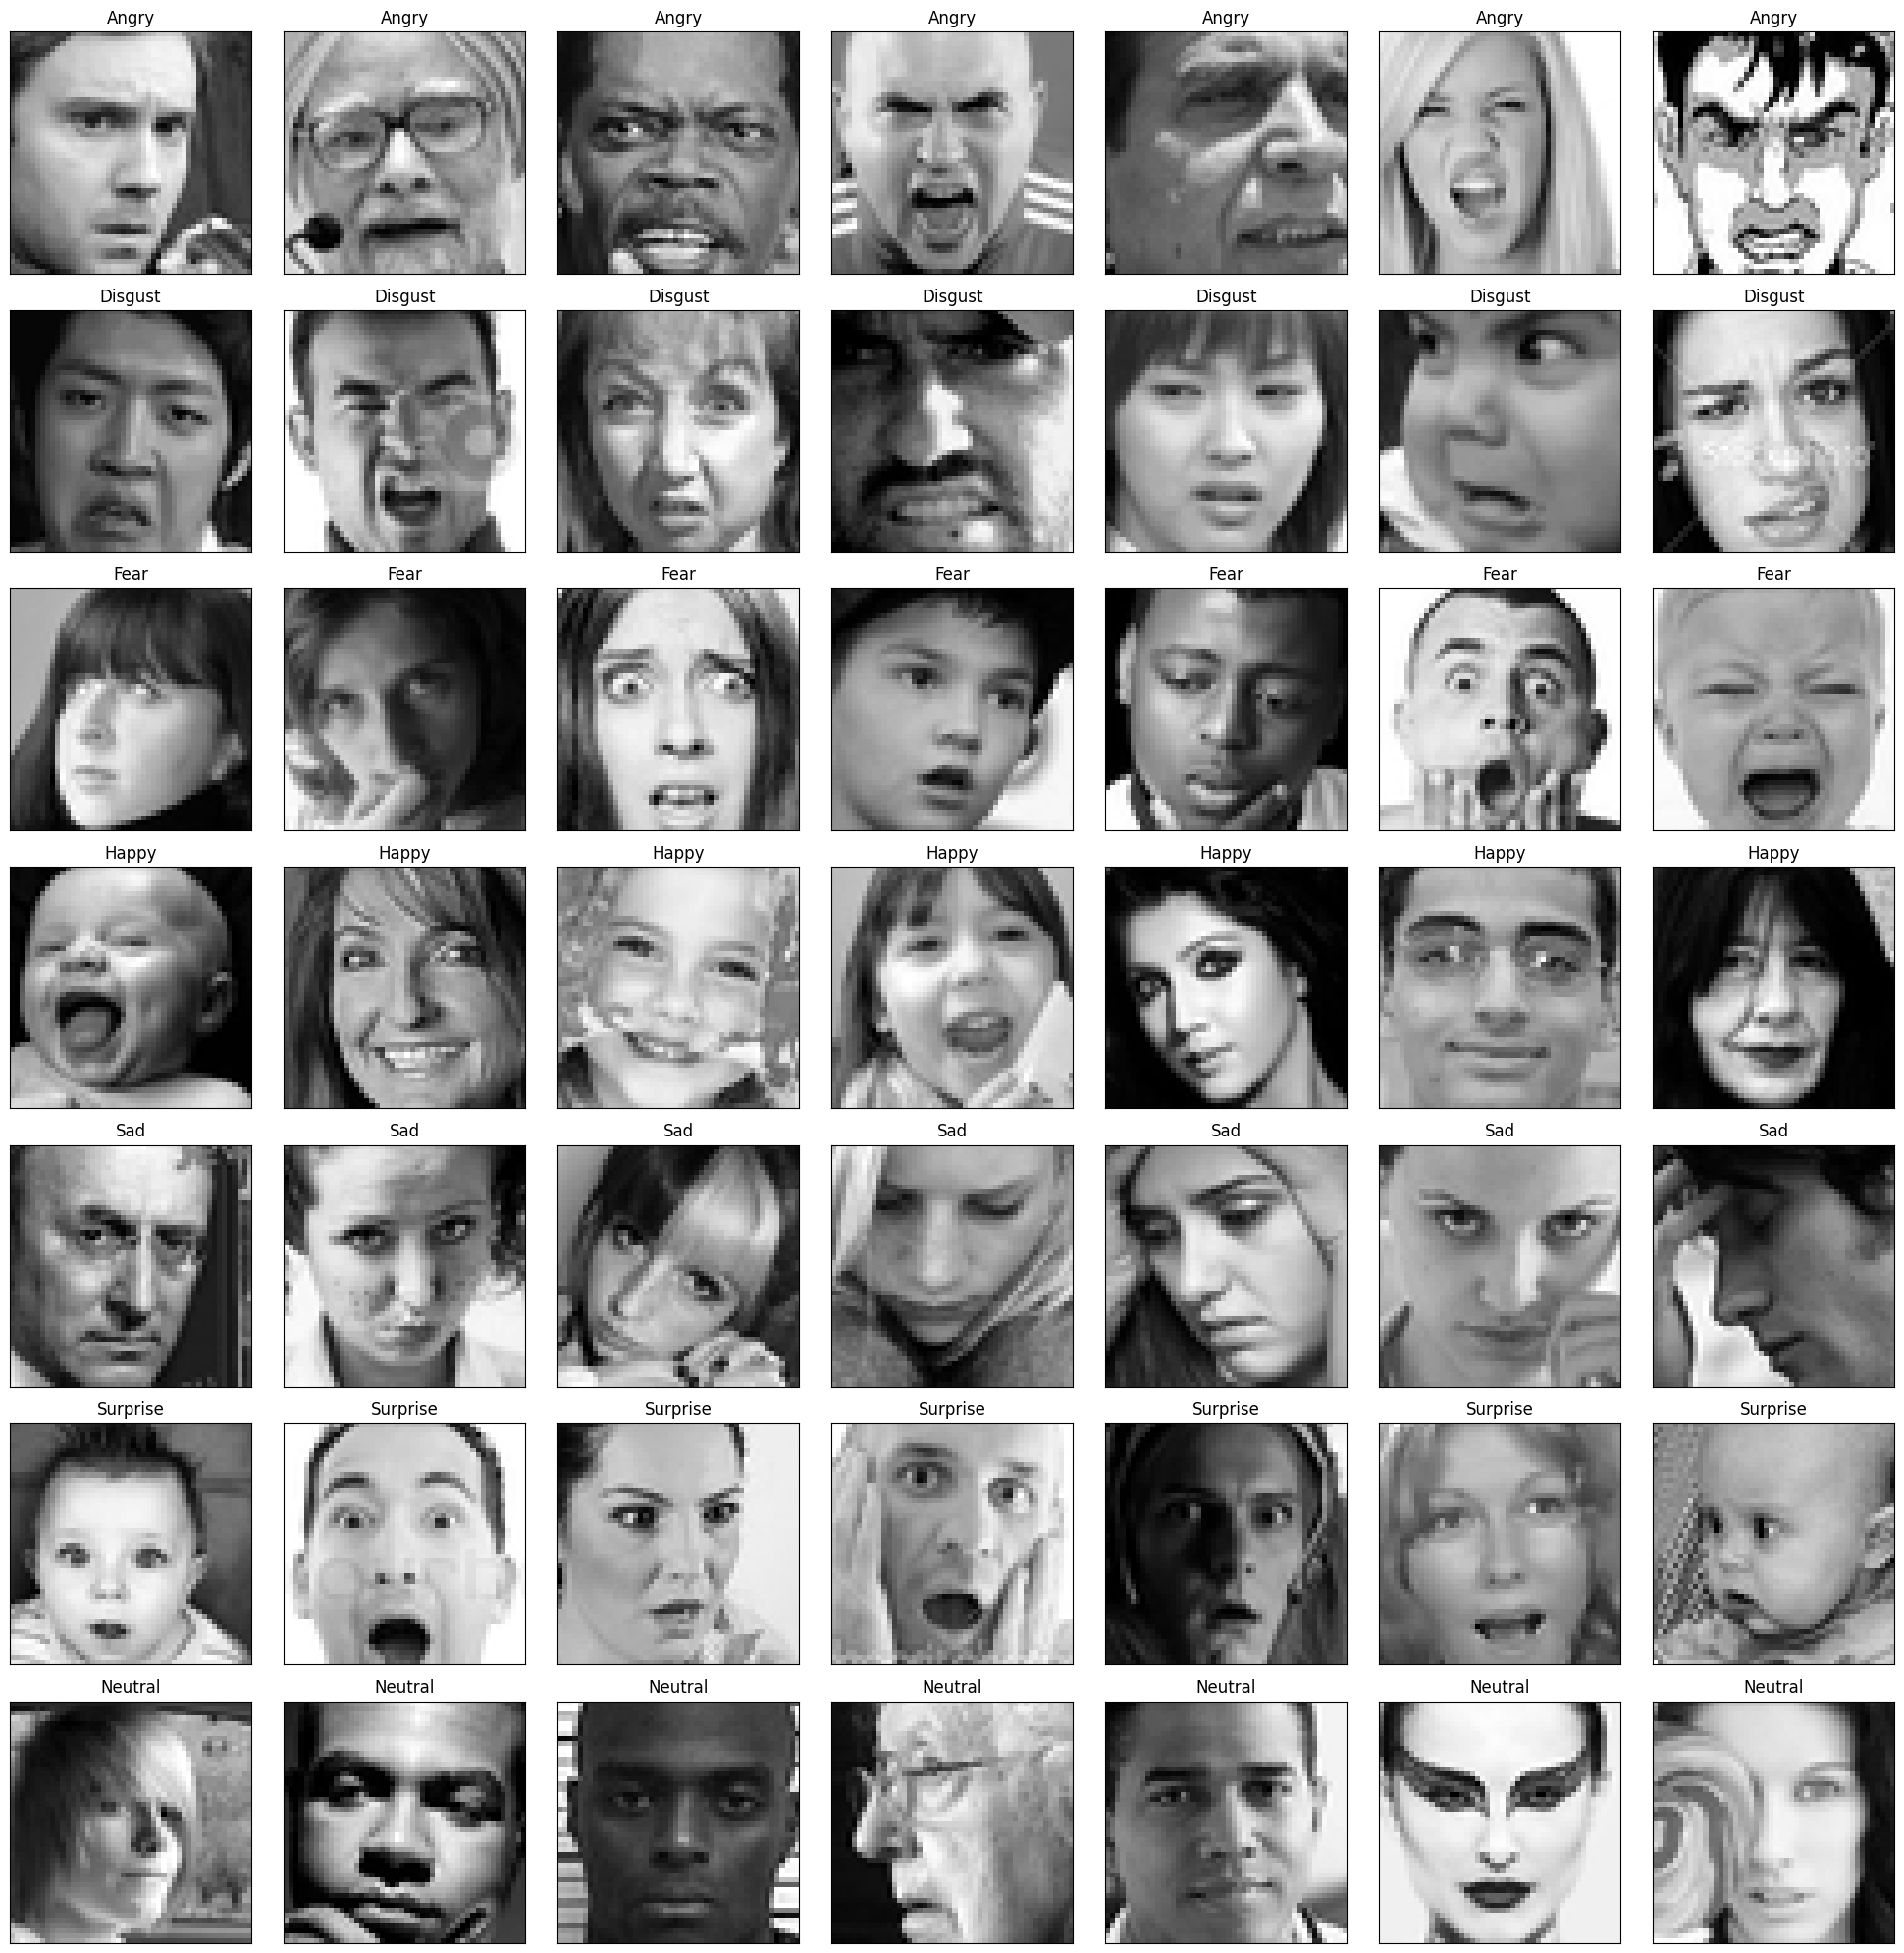

In [9]:
fig = plt.figure(1, (20, 20))

k = 0
for label in sorted(df['emotion'].unique()):
    for j in range(7):
        px = df[df['emotion']==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotions[label])
        plt.tight_layout()

In [10]:
#training data
train_data = df[df['Usage']=='Training']
train_data.drop(columns='Usage', inplace=True)
train_data.head()

<ipython-input-10-25fb927fcf93>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(columns='Usage', inplace=True)


,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [11]:
train_data['pixels'][0]

'70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92

0->black pixel
255->white pixel

In [12]:
#preprocessing
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48, 1))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i, :, :, 0] = image / 255

    return image_array, image_label

In [13]:
X_train, y_train = prepare_data(train_data)
print(X_train.shape, y_train.shape)

(28709, 48, 48, 1) (28709,)


In [14]:
#testing
test_data = df[df['Usage']!='Training']
test_data.drop(columns='Usage', inplace=True)
test_data.head()

#prepare data
X_test, y_test = prepare_data(test_data)
print(X_test.shape, y_test.shape)

<ipython-input-14-b7e821d8a13e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(columns='Usage', inplace=True)


(7178, 48, 48, 1) (7178,)


In [15]:
#train test split
#80% training
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  shuffle=True,
                                                  stratify=y_train,
                                                  test_size=0.2,
                                                  random_state=121)

In [16]:
le = LabelEncoder()#encodes y btw 0-6
y_train = le.fit_transform(y_train)
y_train = keras.utils.to_categorical(y_train)


y_test = le.transform(y_test)
y_test = keras.utils.to_categorical(y_test)


y_val = le.transform(y_val)
y_val = keras.utils.to_categorical(y_val)

print('y_train', y_train.shape)
print('y_test', y_test.shape)
print('y_val', y_val.shape)

y_train (22967, 7)
y_test (7178, 7)
y_val (5742, 7)


To build a powerful image classifier, image augmentation is usually required to boost the performance of deep networks. Image augmentation artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc of each training instances. The purpose is to improve the model generalization capability. The model will be now able to see all the different variations of the images so it would be able to generalize better and avoid over fitting.

In [17]:
img_size = 48
batch_size = 32


datagen = ImageDataGenerator(rotation_range=25,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True)

datagen.fit(X_train)
datagen.fit(X_val)

CNN architecture is composed of convolutional layer with ReLU, pooling layer, and lastly fully connected layer.

In [18]:
model = Sequential()

#1st conv
model.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1))) #1 is for grayscale
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#2nd conv
model.add(Conv2D(128, (5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#3rd conv
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#4th conv
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

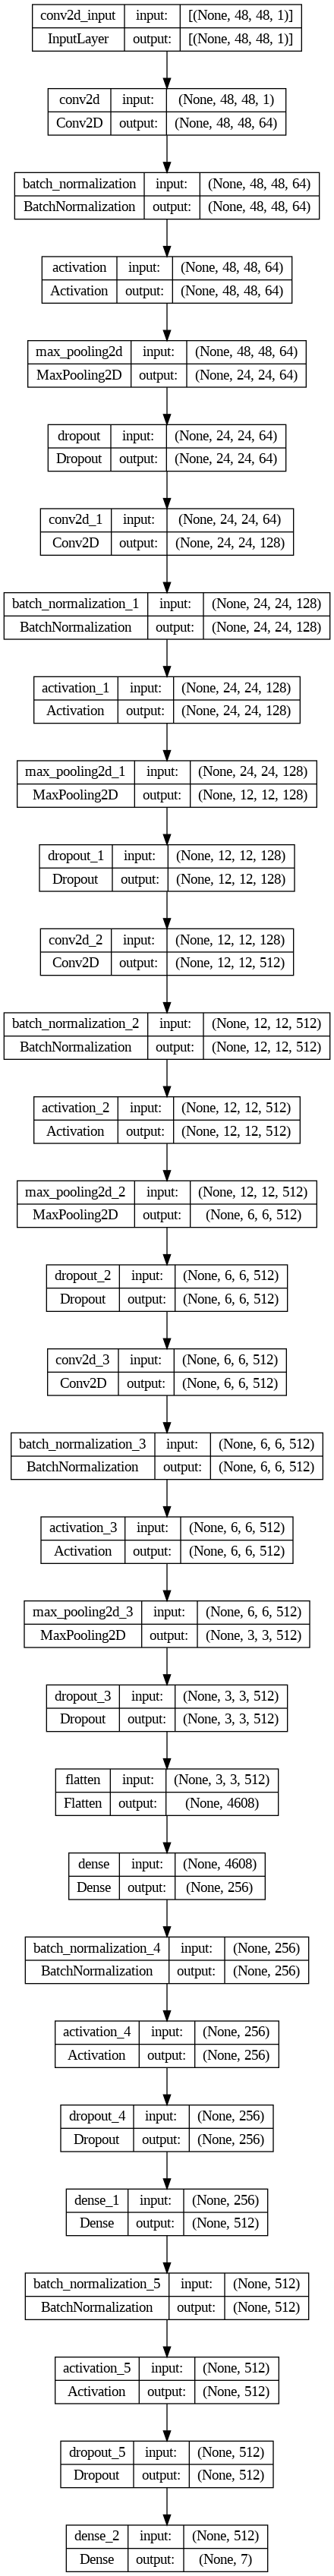

In [19]:
plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

optimizer = Adam is the most popular optimizer currently.
loss = 'categorical_crossentropy because this is a multi-class classification problem.
metrics = ['accuracy']

In [20]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-5),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [21]:
epochs = 5

checkpoint = ModelCheckpoint('model_weights.h5',
                             monitor='val_accuracy',
                             save_weights_only=True,
                             mode='max',
                             verbose=1)


reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=2,
                              min_lr=0.00001,
                              mode='min')


earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5,
                          mode='max',
                          verbose=1)

callbacks = [earlystop,
             checkpoint,
             reduce_lr]

In [22]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs,
                    callbacks=callbacks)

Epoch 1/5
718/717 [==============================] - ETA: 0s - loss: 2.1662 - accuracy: 0.1870
Epoch 1: saving model to model_weights.h5
717/717 [==============================] - 1260s 2s/step - loss: 2.1662 - accuracy: 0.1870 - val_loss: 1.8108 - val_accuracy: 0.2644 - lr: 1.0000e-05
Epoch 2/5
718/717 [==============================] - ETA: 0s - loss: 2.0471 - accuracy: 0.2216
Epoch 2: saving model to model_weights.h5
717/717 [==============================] - 1232s 2s/step - loss: 2.0471 - accuracy: 0.2216 - val_loss: 1.8050 - val_accuracy: 0.2658 - lr: 1.0000e-05
Epoch 3/5
718/717 [==============================] - ETA: 0s - loss: 1.9939 - accuracy: 0.2334
Epoch 3: saving model to model_weights.h5
717/717 [==============================] - 1231s 2s/step - loss: 1.9939 - accuracy: 0.2334 - val_loss: 1.7858 - val_accuracy: 0.2760 - lr: 1.0000e-05
Epoch 4/5
718/717 [==============================] - ETA: 0s - loss: 1.9408 - accuracy: 0.2520
Epoch 4: saving model to model_weights.h5
71

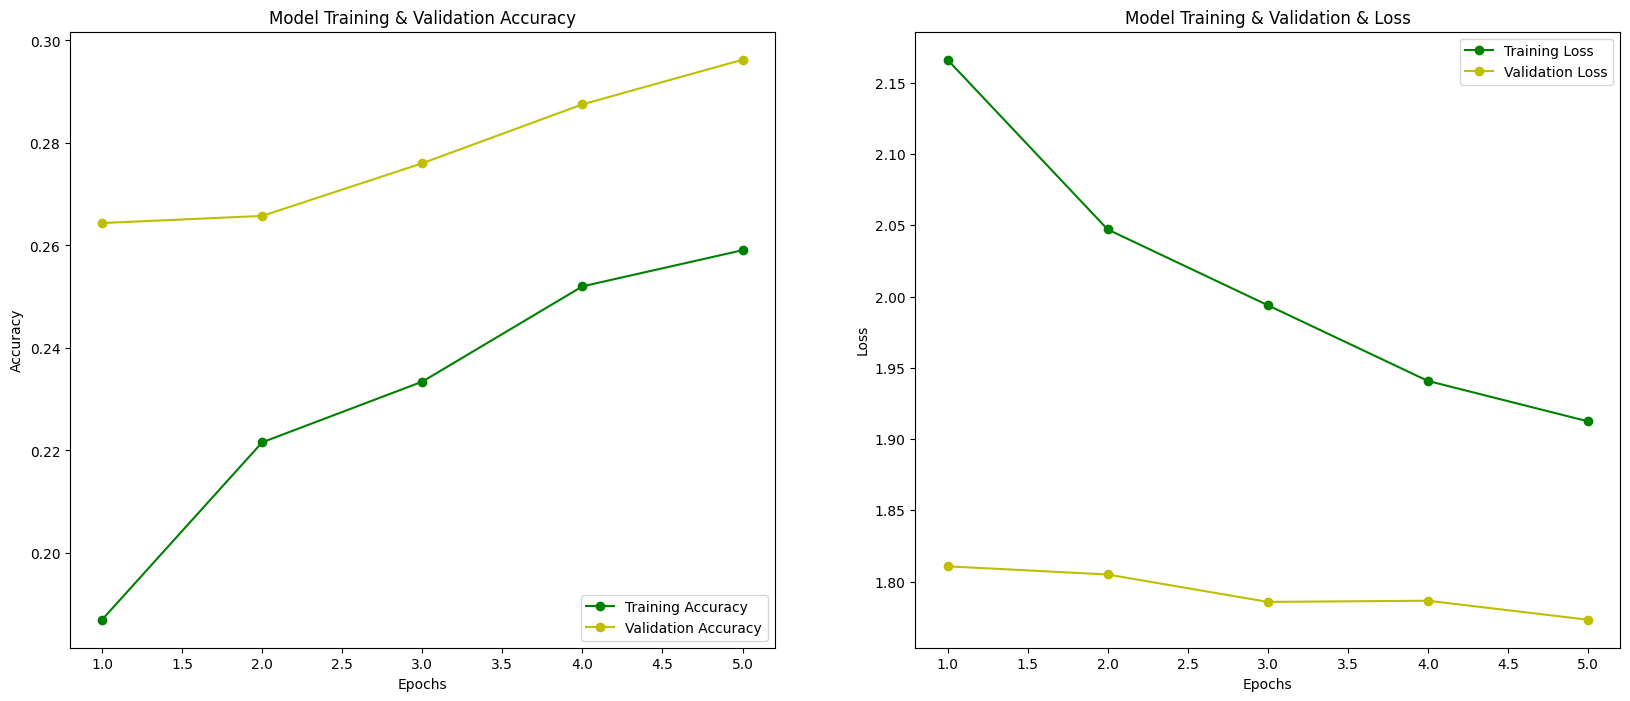

In [23]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs , train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('Model Training & Validation & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [24]:
print('Train accuracy & loss:', model.evaluate(X_train, y_train))
print('\n')
print('Test accuracy & loss:', model.evaluate(X_test, y_test))

718/718 [==============================] - 281s 391ms/step - loss: 1.7735 - accuracy: 0.2959
Train accuracy & loss: [1.7734965085983276, 0.2959463596343994]


225/225 [==============================] - 89s 393ms/step - loss: 1.7809 - accuracy: 0.2885
Test accuracy & loss: [1.7809226512908936, 0.288520485162735]


In [ ]:
#make prediction
y_test = np.argmax(y_test, axis=1)
yhat_test = np.argmax(model.predict(X_test), axis=1)

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

#get confusion matrix
cm = confusion_matrix(y_test, yhat_test)
print(cm)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = emotions.values())

cm_display.plot()
plt.show()

In [27]:
#get classification report
print(classification_report(y_test, yhat_test, target_names=emotions.values()))

              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00       958
     Disgust       0.00      0.00      0.00       111
        Fear       0.22      0.01      0.03      1024
       Happy       0.32      0.80      0.46      1774
         Sad       0.22      0.05      0.08      1247
    Surprise       0.34      0.01      0.02       831
     Neutral       0.24      0.46      0.31      1233

    accuracy                           0.29      7178
   macro avg       0.19      0.19      0.13      7178
weighted avg       0.23      0.29      0.19      7178



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plt.figure(figsize=[16,16])

for i in range(36):
    img = X_test[i,:,:,0]
    p_dist = model.predict(img.reshape(1, 48, 48, 1))
    k = np.argmax(p_dist)
    p = np.max(p_dist)

    plt.subplot(6, 6, i+1)
    plt.imshow(img, cmap='binary_r')
    plt.title(f'{emotions[y_test[i]]} - ({emotions[k]} - {p:.4f})')
    plt.axis('off')

plt.tight_layout()
plt.show()

USE OF GRAD CAM

Finding the final convolutional layer in the network (find_target_layer function).
Examining the gradient information flowing into that layer (GradientTape).
Computing an importance score based on the gradients to produce a heatmap (compute_heatmap).
Highlighting the important regions within the image that resulted in a given class label (overlay_heatmap).

In [29]:
import cv2
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,self.model.output]
       )

        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
            grads = tape.gradient(loss, convOutputs)

            castConvOutputs = tf.cast(convOutputs > 0, "float32")
            castGrads = tf.cast(grads > 0, "float32")
            guidedGrads = castConvOutputs * castGrads * grads
            convOutputs = convOutputs[0]
            guidedGrads = guidedGrads[0]

            weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
            cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

            (w, h) = (image.shape[2], image.shape[1])
            heatmap = cv2.resize(cam.numpy(), (w, h))
            numer = heatmap - np.min(heatmap)
            denom = (heatmap.max() - heatmap.min()) + eps
            heatmap = numer / denom
            heatmap = (heatmap * 255).astype("uint8")
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap = cv2.COLORMAP_VIRIDIS):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        return (heatmap, output)

1/1 [==============================] - 0s 33ms/step


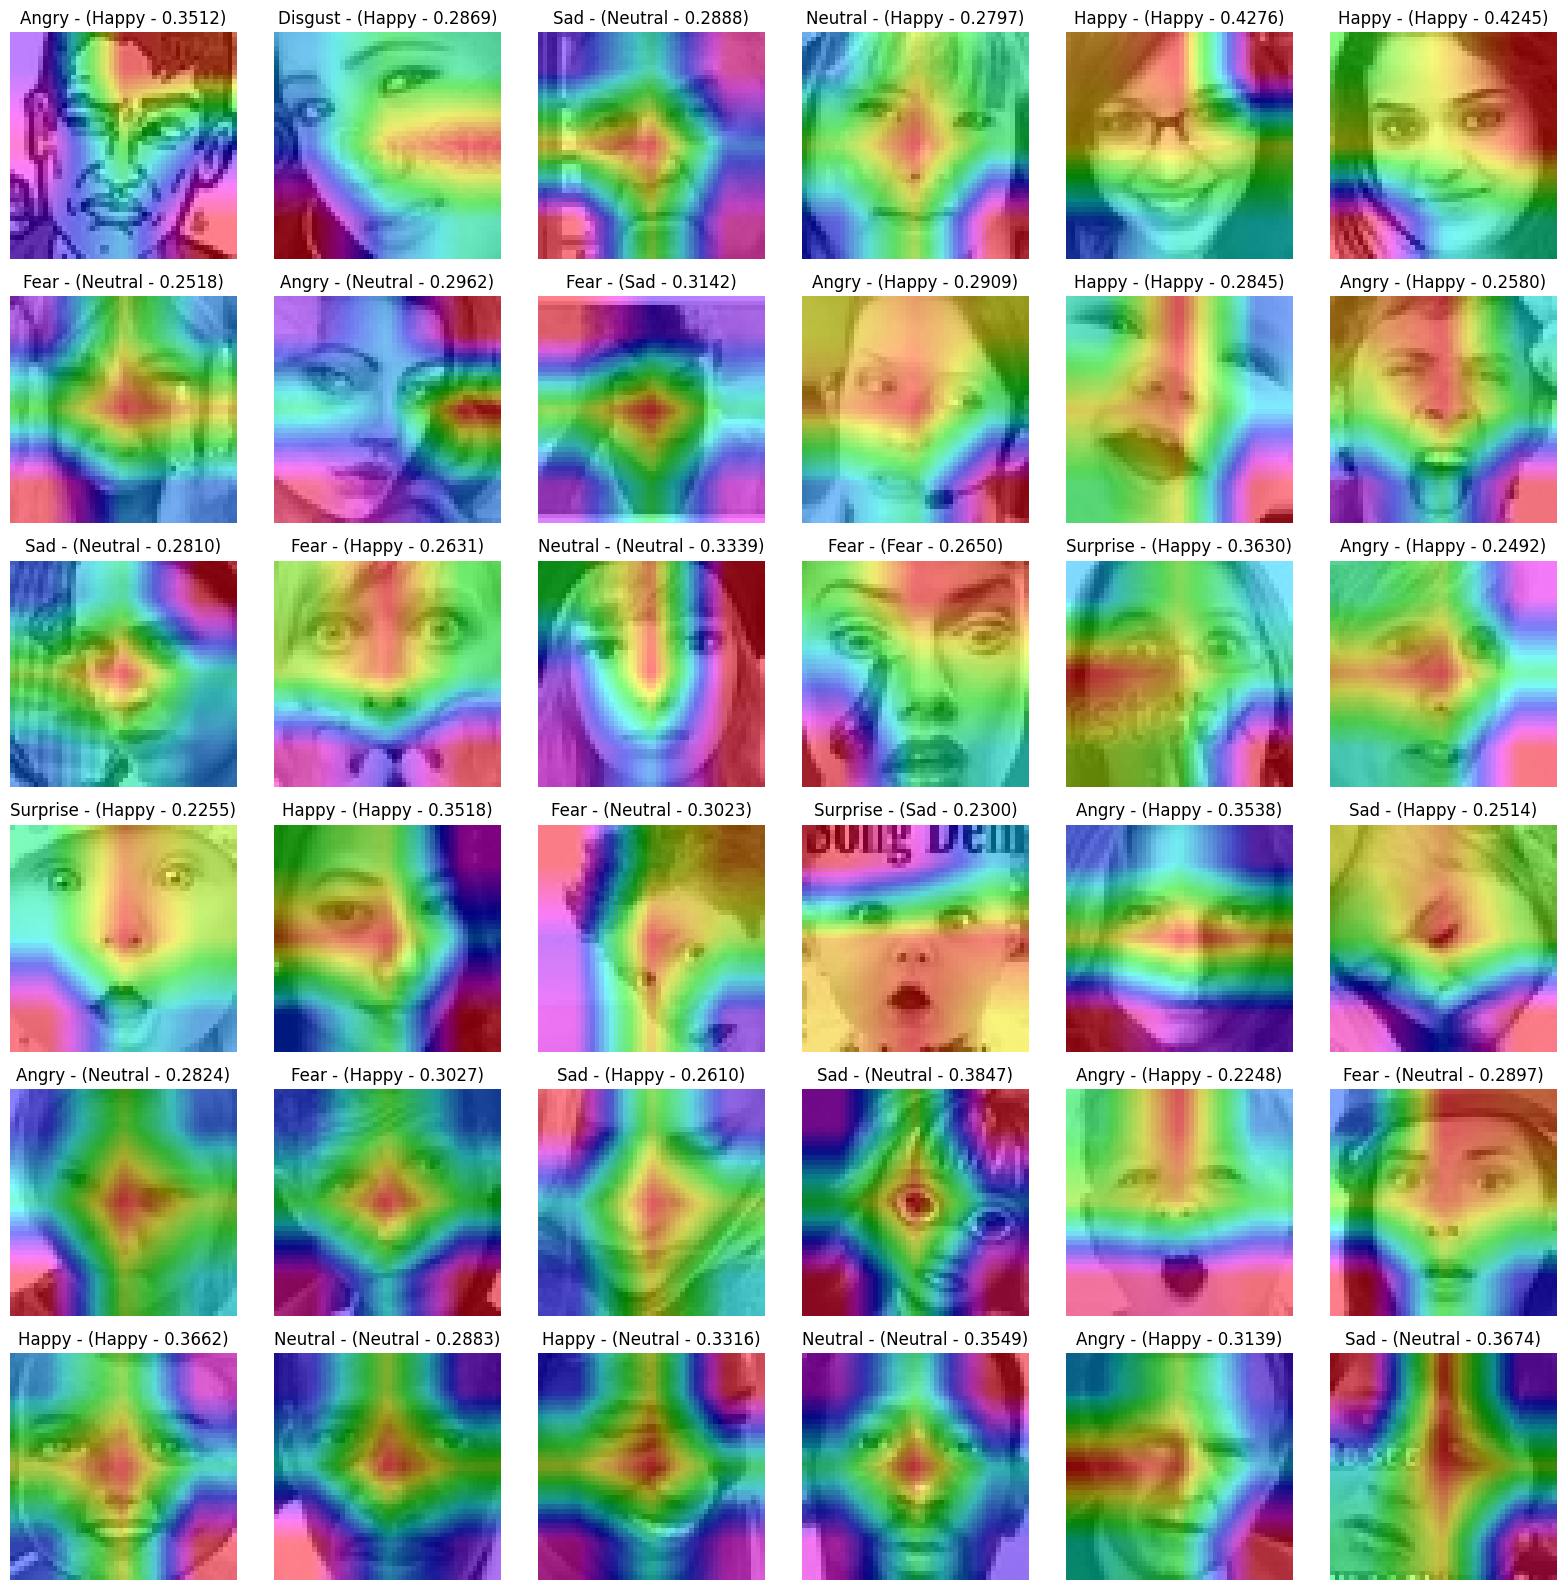

In [30]:
plt.figure(figsize=[16,16])
for i in range(36):
    img = X_test[i,:,:,0]
    p_dist = model.predict(img.reshape(1, 48, 48, 1))
    k = np.argmax(p_dist)
    p = np.max(p_dist)

    cam = GradCAM(model, k)
    heatmap = cam.compute_heatmap(img.reshape(1, 48, 48, 1))

    plt.subplot(6, 6, i+1)
    plt.imshow(img, cmap='binary_r')
    plt.imshow(heatmap, alpha=0.5, cmap='hsv')
    plt.title(f'{emotions[y_test[i]]} - ({emotions[k]} - {p:.4f})')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
test_prob = model.predict(X_test)
test_pred = np.argmax(test_prob, axis=1)

sel_imgs = [33, 1000, 88, 777, 108, 111, 7000]

for n in sel_imgs:
    img = X_test[n,:,:,0]

    plt.figure(figsize=[10,3])
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='binary_r')
    plt.title(f'True Label: {emotions[y_test[n]]}')
    plt.axis('off')

    cam = GradCAM(model, test_pred[n])
    heatmap = cam.compute_heatmap(img.reshape(1,48,48,1))

    plt.subplot(1, 3, 2)
    plt.imshow(img, cmap='binary_r')
    plt.imshow(heatmap, alpha=0.5, cmap='hsv')
    plt.title(f'Predicted Label: {emotions[test_pred[n]]}')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.bar(emotions.values(), test_prob[n, :], color='m', edgecolor='k')
    plt.xticks(rotation=45)
    plt.ylim([0,1])
    plt.title('Distribution of Predictions')
    plt.show()

GradCam++

In [ ]:
import cv2
class GradCamPlus:
  def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()
  def find_target_layer(self):
       for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
       raise ValueError("Could not find 4D layer. Cannot apply GradCAM++.")

  def compute_heatmap(self, image, eps=1e-10):
      gradModel = Model(
          inputs=[self.model.inputs],
          outputs=[self.model.get_layer(self.layerName).output,self.model.output]
       )

      with tf.GradientTape() as gtape1:
        with tf.GradientTape() as gtape2:
            with tf.GradientTape() as gtape3:
              inputs = tf.cast(image, tf.float32)
              conv_output, predictions  = gradModel(inputs)
              output = predictions[:, None]
              conv_first_grad = gtape3.gradient(output, conv_output)
            conv_second_grad = gtape2.gradient(conv_first_grad, conv_output)
        conv_third_grad = gtape1.gradient(conv_second_grad, conv_output)

      global_sum = np.sum(conv_output, axis=(0, 1, 2))
      alpha_num = conv_second_grad[0]
      alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
      alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)

      alphas = alpha_num/alpha_denom
      alpha_normalization_constant = np.sum(alphas, axis=(0,1))
      alphas /= alpha_normalization_constant
      weights = np.maximum(conv_first_grad[0], 0.0)

      deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
      grad_cam_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

      heatmap = np.maximum(grad_cam_map, 0)
      max_heat = np.max(heatmap)
      if max_heat == 0:
        max_heat = 1e-10
      heatmap /= max_heat
      return heatmap

  def overlay_heatmap(self, heatmap, image, alpha=0.5,
      colormap = cv2.COLORMAP_VIRIDIS):
      heatmap = cv2.applyColorMap(heatmap, colormap)
      output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
      return (heatmap, output)

1/1 [==============================] - 0s 34ms/step


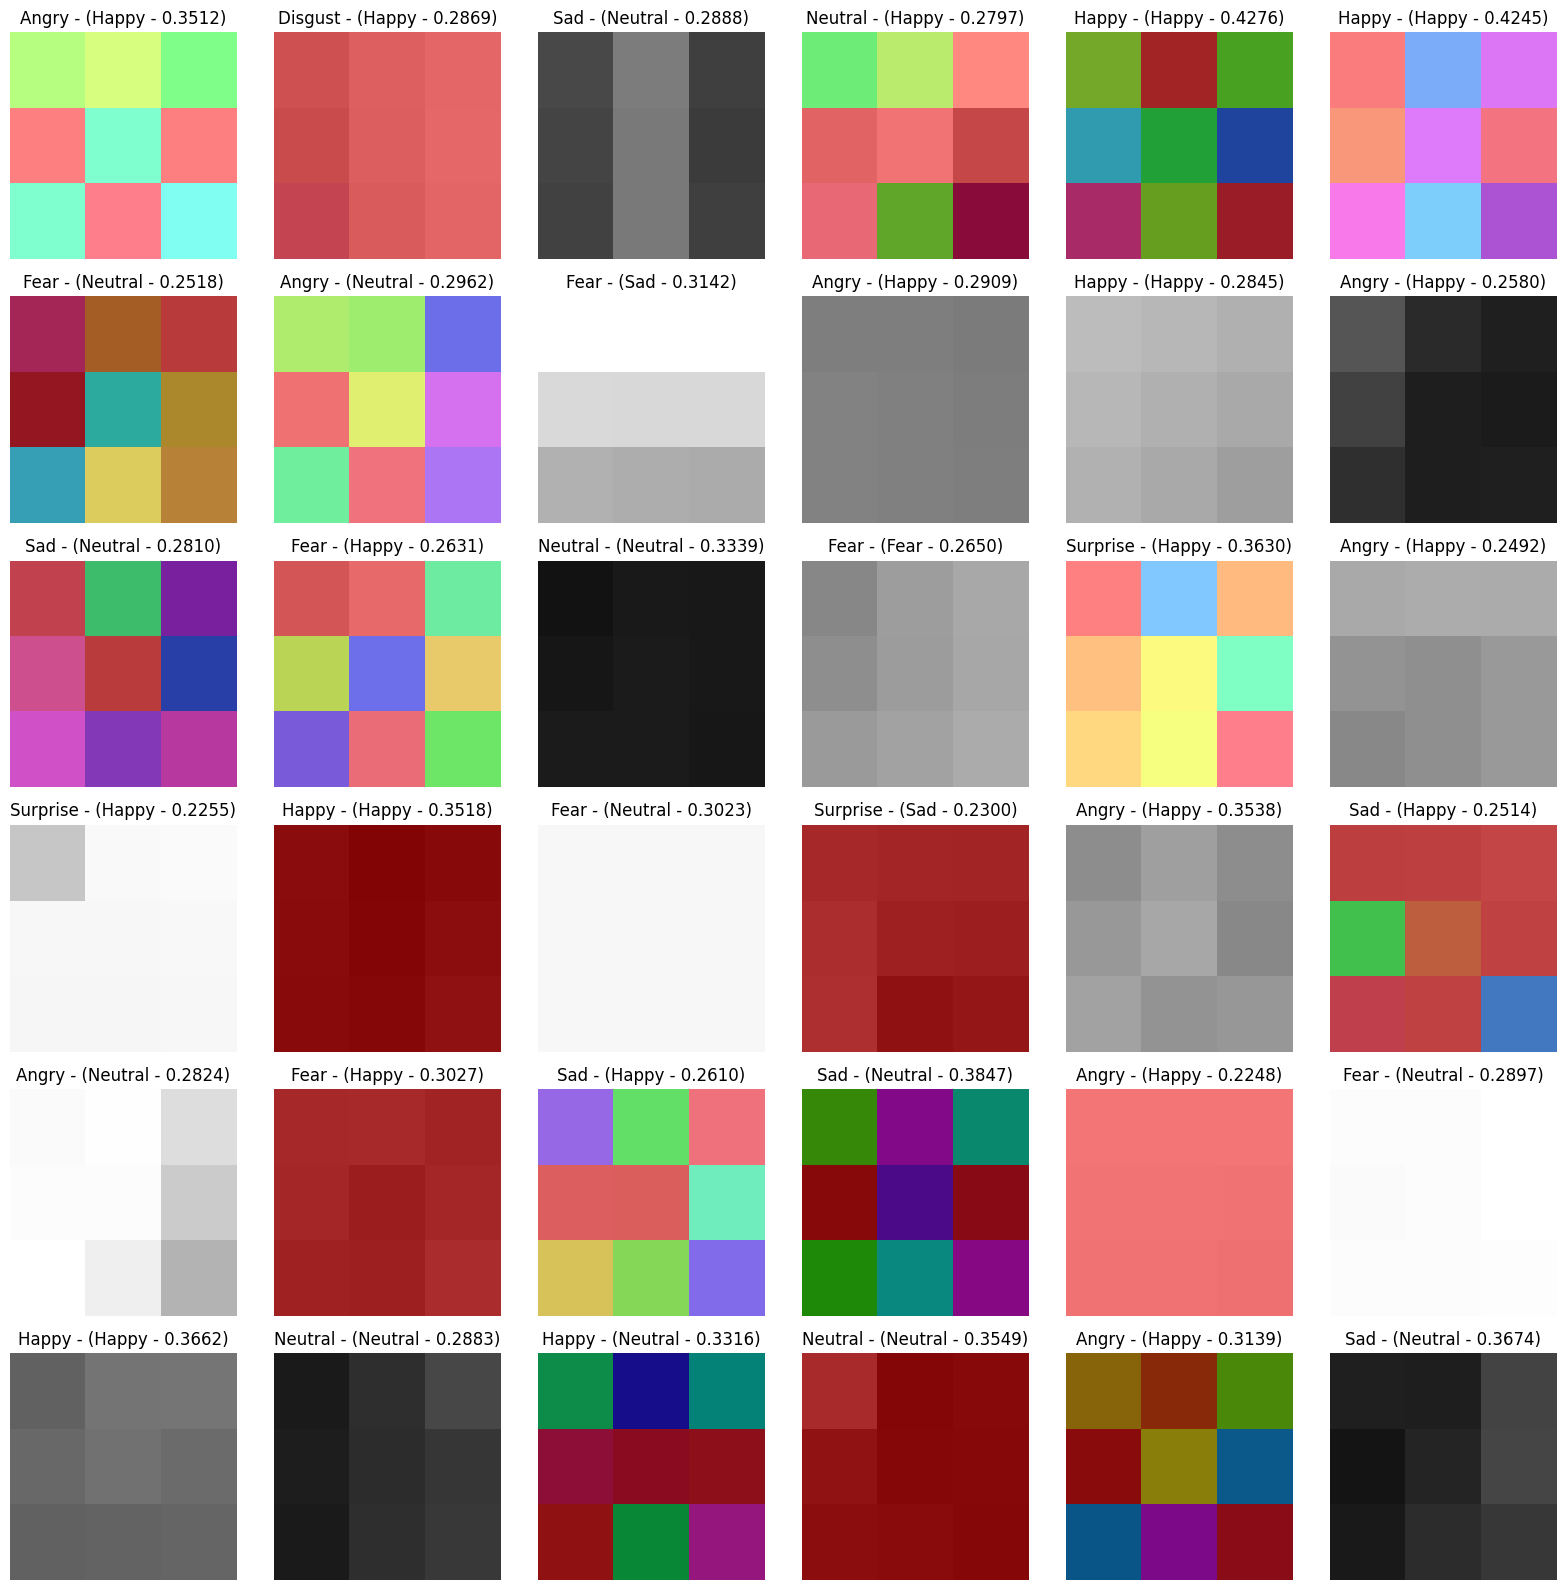

In [33]:
plt.figure(figsize=[16,16])
for i in range(36):
    img = X_test[i,:,:,0]
    p_dist = model.predict(img.reshape(1, 48, 48, 1))
    k = np.argmax(p_dist)
    p = np.max(p_dist)

    cam = GradCamPlus(model, k)
    heatmap = cam.compute_heatmap(img.reshape(1, 48, 48, 1))

    plt.subplot(6, 6, i+1)
    plt.imshow(img, cmap='binary_r')
    plt.imshow(heatmap, alpha=0.5, cmap='hsv')
    plt.title(f'{emotions[y_test[i]]} - ({emotions[k]} - {p:.4f})')
    plt.axis('off')

plt.tight_layout()
plt.show()